# Classify particle motion from MSD anaysis and bayesian inference (in construction)

This analysis is largely inspired from the following paper _Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_.

The idea is to classify particle motion in different biophysical model : diffusion, confined movement, direct, and so forth.

The input of the analysis is MSD curves of several particles (under same condition) and the output is a set of probability for different models.

For more details, the papier is available here : http://www.cell.com/biophysj/abstract/S0006-3495(12)00718-7

For a complete introduction of bayesian statistic, I strongly encourage you to read this excellent book : [Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb).

TODO: introduce the theory

![model](model.png)

_Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy import io
from scipy import optimize

import pymc3 as pm
import theano
import theano.tensor as t

import matplotlib.pyplot as plt

## Load chromosomes MSD curves

Corresponds to Fig. 4 A-C in the paper.

![chromosomes](chromosomes.png)

_Monnier, N. (2012). Bayesian Approach to MSD-Based Analysis of Particle Motion in Live Cells. Biophysical Journal_

In [2]:
# Chromosomes traj
mat = io.loadmat('chromosomes.mat')
msds = mat['MSD_curves_chromosomes']
msds = pd.DataFrame(msds)
msds["delay"] = mat['timelags'].T[0]
msds.set_index("delay", drop=True, inplace=True)
msds.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
delay,,,,,,,,,,,,,,,,,,,,,
2.6,0.097573,0.373977,0.076612,0.068739,0.062353,0.036330,0.153783,0.099404,0.204890,0.292111,...,0.161717,0.132908,0.276165,0.134094,0.178738,0.175778,0.256930,0.169733,0.117894,0.262046
5.2,0.196207,0.351178,0.128585,0.123823,0.147403,0.061929,0.301612,0.227539,0.464767,0.573292,...,0.405083,0.334022,0.662523,0.338944,0.434863,0.418021,0.650792,0.432889,0.309397,0.589823
7.8,0.331055,0.470176,0.176194,0.198717,0.260169,0.092897,0.485697,0.379726,0.783481,0.893782,...,0.726817,0.593216,1.095236,0.588966,0.738894,0.725592,1.128657,0.770092,0.555813,0.947340
10.4,0.464399,0.473161,0.232980,0.281506,0.388835,0.133016,0.682776,0.554917,1.164619,1.313681,...,1.115730,0.932779,1.593391,0.893019,1.100812,1.095992,1.713535,1.185670,0.852484,1.355115
13.0,0.588834,0.479392,0.276361,0.364231,0.531622,0.175939,0.913439,0.759349,1.602612,1.764976,...,1.624899,1.348220,2.226334,1.278424,1.561110,1.566704,2.423151,1.691124,1.214357,1.832992


Display all the MSD curves

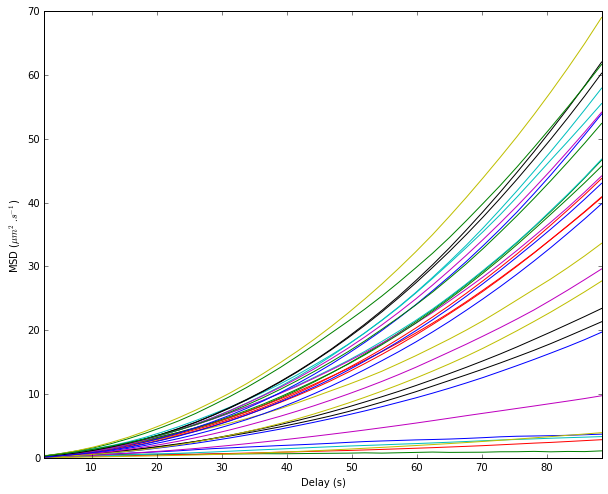

In [3]:
fig, ax = plt.subplots(figsize=(10, 8))
msds.plot(ax=ax, legend=False)

ax.set_xlabel('Delay (s)')
ax.set_ylabel('MSD ($\mu m^2.s^{-1}$)')

Display the average MSD (with std and sem)

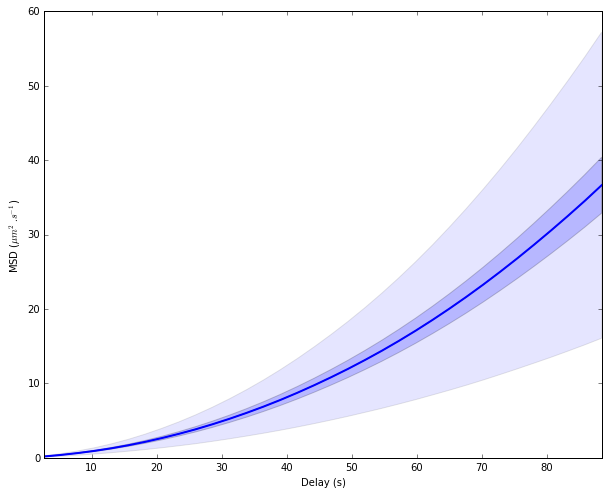

In [4]:
msd_mean = msds.mean(axis=1)
msd_std = msds.std(axis=1)
msd_sem = msds.sem(axis=1)

fig, ax = plt.subplots(figsize=(10, 8))
msd_mean.plot(ax=ax, lw=2)

# std
ax.fill_between(msd_mean.index, msd_mean, msd_mean + msd_std, alpha=0.1)
ax.fill_between(msd_mean.index, msd_mean, msd_mean - msd_std, alpha=0.1)

# sem
ax.fill_between(msd_mean.index, msd_mean, msd_mean + msd_sem, alpha=0.2)
ax.fill_between(msd_mean.index, msd_mean, msd_mean - msd_sem, alpha=0.2)

ax.set_xlabel('Delay (s)')
ax.set_ylabel('MSD ($\mu m^2.s^{-1}$)')

## Naive implementation from Matlab code

Matlab code is available here : http://msd-bayes.org/

### Covariance matrix

In `msd_curves_bayes.m`.

In [40]:
# Get the average MSD
msd_mean = msds.mean(axis=1)

# Get difference between each individual curve and the mean curve
errors = msds.copy()
for i, col in msds.iteritems():
    errors.loc[:, i] = col - msd_mean

# Calculate raw covariance matrix
error_cov_raw = np.cov(errors)

# Regularize covariance matrix (TODO)
error_cov = error_cov_raw.copy()

# Covariance of the mean curve
error_cov_raw /= errors.shape[0]
error_cov /= errors.shape[0]

Display the covariance matrix.

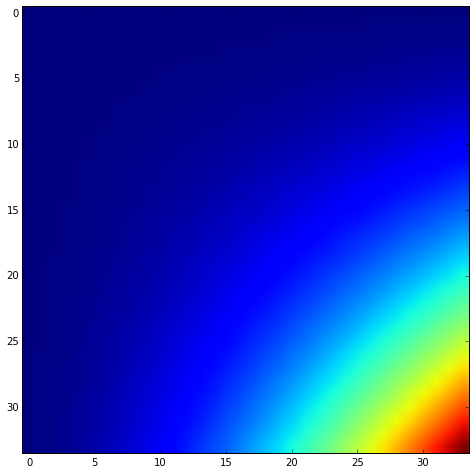

In [41]:
plt.figure(figsize=(8, 8))
plt.imshow(error_cov)

### Fitting

In `msd_fitting.m`.

#### Brownian diffusion

Fit the following equation : $MSD(\tau) = 6D\tau$

In [11]:
# Purely diffusive model

def msd_model(tau, D_coeff):
    return 6 * D_coeff * tau

msd_observed = msd_mean.copy()
tau = msd_mean.index

popt, pcov = optimize.curve_fit(msd_model, tau, msd_observed)
errors = np.sqrt(np.diag(pcov))

print("Estimate for D coeff is {:.2f} with variance = {:.5f}".format(popt[0], errors[0]))

Estimate for D coeff is 0.05 with variance = 0.00217


In [101]:
# Constant model

def msd_model(tau, sigma_e):
    return 6 * sigma_e ** 2

msd_observed = msd_mean.copy()
tau = msd_mean.index

popt, pcov = optimize.curve_fit(msd_model, tau, msd_observed)
errors = np.sqrt(np.diag(pcov))

print("Estimate for sigma_e is {:.2f} with variance = {:.5f}".format(popt[0], errors[0]))

Estimate for sigma_e is 1.48 with variance = 0.10822


In [106]:
# Diffusive + error model

def msd_model(tau, D_coeff, sigma_e):
    return 6 * D_coeff * tau + 6 * sigma_e ** 2

msd_observed = msd_mean.copy()
tau = msd_mean.index

popt, pcov = optimize.curve_fit(msd_model, tau, msd_observed)
errors = np.sqrt(np.diag(pcov))

print("Estimate for D coeff is {:.2f} with variance = {:.5f}".format(popt[0], errors[0]))
print("Estimate for sigma_e is {:.2f} with variance = {:.5f}".format(popt[1], errors[1]))

Estimate for D coeff is 0.05 with variance = inf
Estimate for sigma_e is -0.00 with variance = inf


/home/hadim/local/conda/envs/st/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Implementation with PyMC3

See https://pymc-devs.github.io/pymc3/getting_started/#a-motivating-example-linear-regression for an introduction to PyMC3.

### Brownian diffusion

Fit the following equation : $MSD(\tau) = 6D\tau$

 [-----------------100%-----------------] 1000 of 1000 complete in 0.8 sec
Estimate for D coeff is 0.05 with variance unknown


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59a9050ba8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f59a8d854a8>]], dtype=object)

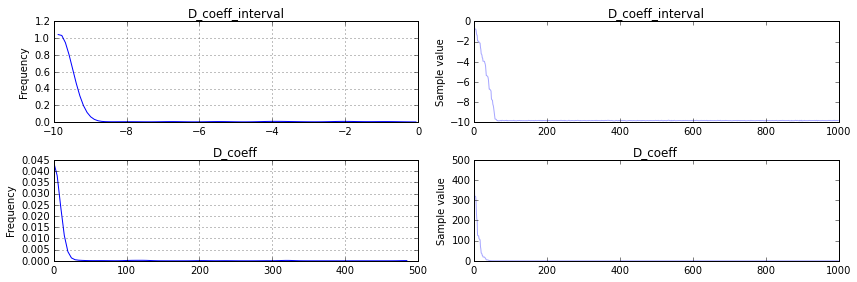

In [13]:
# Purely diffusive model

msd_observed = msd_mean.copy()

with pm.Model() as model:
    
    D_coeff = pm.Uniform("D_coeff", lower=0, upper=1000)
    
    tau = msd_mean.index
    msd_model = 6 * D_coeff * tau
    
    observation = pm.Normal("observation", mu=msd_model, observed=msd_observed)
    
    step = pm.NUTS()
    trace = pm.sample(1000, step, )
    
print("\nEstimate for D coeff is {:.2f} with variance unknown".format(trace["D_coeff"][-1]))
pm.traceplot(trace)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.6 sec
Estimate for sigma_e is 1.47 with variance unknown


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f59abdcbb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f59abc9f438>]], dtype=object)

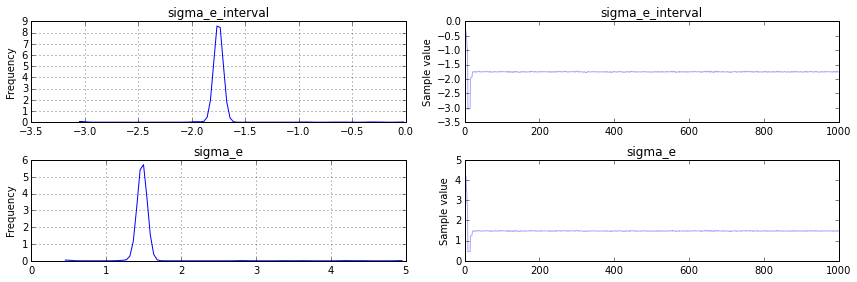

In [10]:
# Constant model

msd_observed = msd_mean.copy()

with pm.Model() as model:
    
    sigma_e = pm.Uniform("sigma_e", lower=0, upper=10)
    
    tau = msd_mean.index
    msd_model = 6 * sigma_e ** 2
    
    observation = pm.Normal("observation", mu=msd_model, observed=msd_observed)
    
    step = pm.NUTS()
    trace = pm.sample(1000, step)
    
print("\nEstimate for sigma_e is {:.2f} with variance unknown".format(trace["sigma_e"][-1]))
pm.traceplot(trace)

 [-----------------100%-----------------] 1000 of 1000 complete in 20.1 sec
Estimate for D coeff is 0.05 with variance unknown
Estimate for sigma_e is 0.06 with variance unknown


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efec201f390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7efec19d4da0>]], dtype=object)

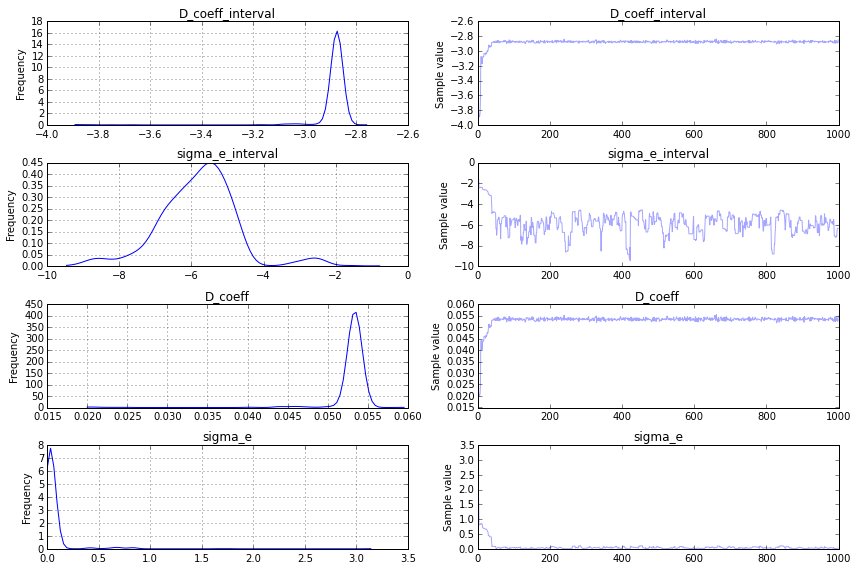

In [118]:
# Diffusive + error model

msd_observed = msd_mean.copy()

with pm.Model() as model:
    
    D_coeff = pm.Uniform("D_coeff", lower=0, upper=1)
    sigma_e = pm.Uniform("sigma_e", lower=0, upper=10)
    
    tau = msd_mean.index
    msd_model = 6 * sigma_e ** 2 + 6 * D_coeff * tau
    
    observation = pm.Normal("observation", mu=msd_model, observed=msd_observed)
    
    step = pm.NUTS()
    trace = pm.sample(1000, step)

print("\nEstimate for D coeff is {:.2f} with variance unknown".format(trace["D_coeff"][-1]))
print("Estimate for sigma_e is {:.2f} with variance unknown".format(trace["sigma_e"][-1]))
pm.traceplot(trace)

### WIP

** IN CONSTRUCTION **
based on http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb#Introducing-our-first-hammer:-PyMC

In [14]:
%matplotlib qt
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy import io
from scipy import optimize

import pymc3 as pm
import theano
import theano.tensor as t

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
count_data = np.loadtxt("txtdata.csv")
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", edgecolor="none")

<Container object of 74 artists>

In [17]:
count_data = np.loadtxt("txtdata.csv")

alpha = 1.0 / count_data.mean()  # Recall count_data is the variable that holds our txt counts

with pm.Model() as model:

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)

    tau = pm.DiscreteUniform("tau", lower=0, upper=1000)

    days = np.arange(len(count_data))
    lambda_ = pm.switch(tau >= days, lambda_1, lambda_2)
    
    observation = pm.Poisson("observation", mu=lambda_, observed=count_data)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, step)
    
print()
print("tau", trace['tau'][-1])
print("lambda_1", trace['lambda_1'][-1])
print("lambda_2", trace['lambda_2'][-1])

 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec
tau 420
lambda_1 20.2579431183
lambda_2 16.8948103995


In [21]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5990e565c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f599074b4a8>]], dtype=object)

In [20]:
tau = trace['tau'][-1]
lambda_1 = trace['lambda_1'][-1]
lambda_2 = trace['lambda_2'][-1]

mcount = np.zeros(count_data.shape)
mcount[:tau] = lambda_1
mcount[tau:] = lambda_2

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", edgecolor="none")
plt.plot(mcount, lw=4, color="#E24A33")

In [20]:
count_data = np.loadtxt("txtdata.csv")

@theano.compile.ops.as_op(itypes=[t.lscalar, t.lscalar, t.dscalar, t.dscalar, t.dscalar], otypes=[t.dvector])
def lambda_(tau1, tau2, lambda_1, lambda_2, lambda_3):
    out = np.zeros(len(count_data))
    out[:tau1] = lambda_1  # lambda before tau is lambda1
    out[tau1:tau2] = lambda_2  # lambda before tau is lambda1
    out[tau2:] = lambda_3  # lambda after (and including) tau is lambda2
    return out

alpha = 1.0 / count_data.mean()  # Recall count_data is the variable that holds our txt counts

with pm.Model() as model:

    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    lambda_3 = pm.Exponential("lambda_3", alpha)

    tau1 = pm.DiscreteUniform("tau1", lower=0, upper=len(count_data))
    tau2 = pm.DiscreteUniform("tau2", lower=0, upper=len(count_data))
    
    observation = pm.Poisson("observation", mu=lambda_(tau1, tau2, lambda_1, lambda_2, lambda_3),
                             observed=count_data)
    
    step = pm.Metropolis()
    trace = pm.sample(500, step)
    
print()
print("tau1", trace['tau1'].mean())
print("tau2", trace['tau2'].mean())

print("lambda_1", trace['lambda_1'].mean())
print("lambda_2", trace['lambda_2'].mean())
print("lambda_3", trace['lambda_3'].mean())

 [-----------------100%-----------------] 500 of 500 complete in 1.2 sec
tau1 31.98
tau2 43.428
lambda_1 20.0860714984
lambda_2 11.2130436917
lambda_3 22.6260011902


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe57515eef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe56e934c18>]], dtype=object)

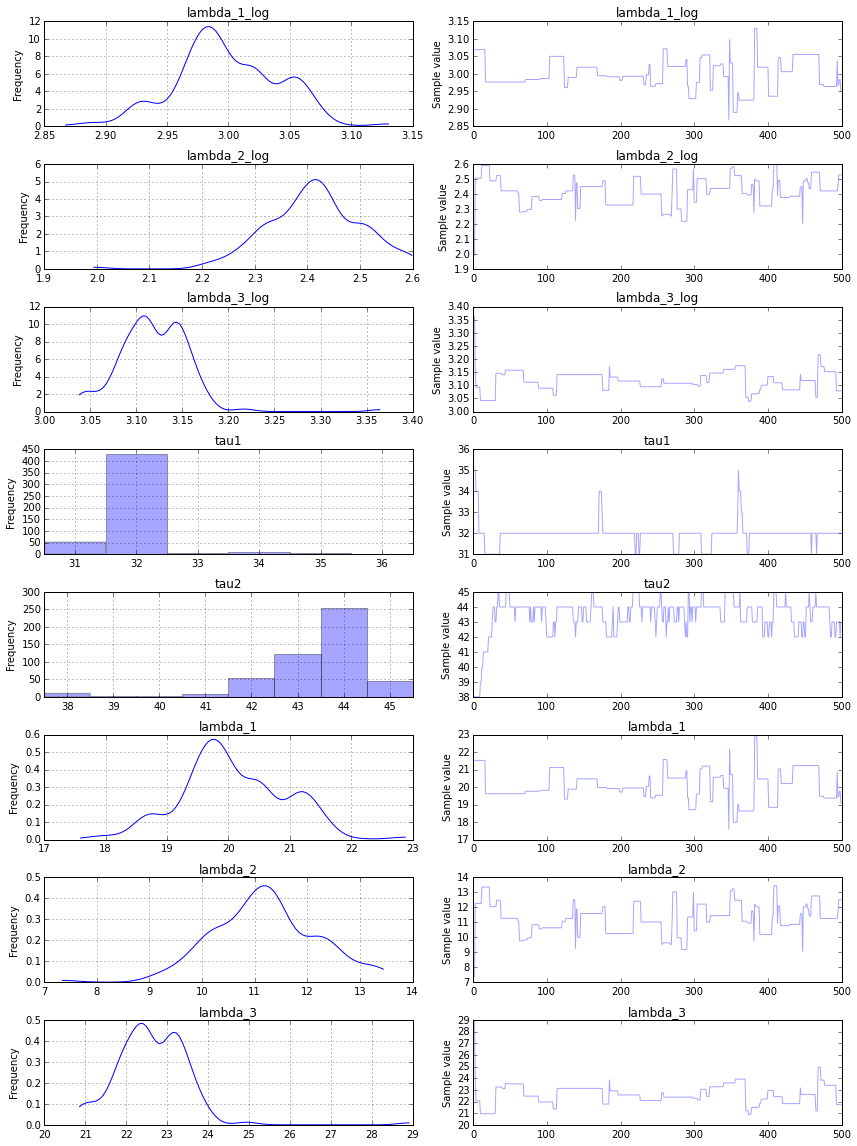

In [21]:
pm.traceplot(trace)

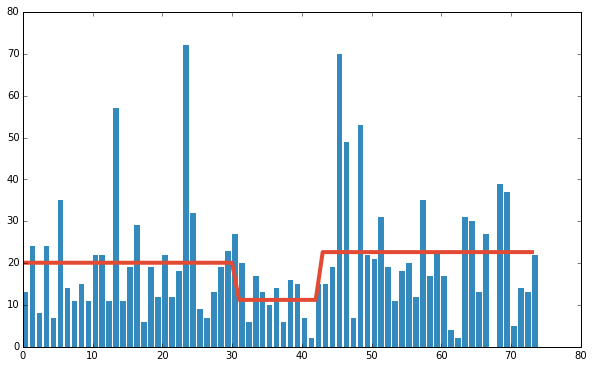

In [22]:
tau1 = trace['tau1'].mean()
tau2 = trace['tau2'].mean()
lambda_1 = trace['lambda_1'].mean()
lambda_2 = trace['lambda_2'].mean()
lambda_3 = trace['lambda_3'].mean()

mcount = np.zeros(count_data.shape)
mcount[:tau1] = lambda_1
mcount[tau1:tau2] = lambda_2
mcount[tau2:] = lambda_3

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", edgecolor="none")
plt.plot(mcount, lw=4, color="#E24A33")